# Spectra acquisiton
Control both the stepping motor and the camera from this notebook.<br>
Make a loop to measure a wide-range spectrum automatically.

NOTE: only one connection to COM port is possible at a time. Shut down other connections, either in python or dedicated software.

In [1]:
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [2]:
import time, os, logging
from FLI import FLI
import numpy as np
import xarray as xr
import datetime
from os.path import join,exists
from os import listdir
import matplotlib.pyplot as plt
import tqdm
# from graph_tools import *

In [3]:
%run thr640.py
%run imaging_tool.py

In [4]:
logger = logger
logger.setLevel(50) # 10 - DEBUG 50 - CRITICAL 20 - INFO
camera = FLI()
step_motor = THR640() # Can only have one instance.

In [5]:
basepath = r'\\10.249.254.51\Public\BACK_UP\oshioka\data\FLI_data\20240207'
# basepath = r'C:\Users\fujii\Documents\python\kuzmin\kurokawa\20221111'
if not os.path.exists(basepath):
    os.makedirs(basepath)

In [6]:
ccw_limit = 0
cw_limit = 1030000

In [7]:
balmers = np.array([777.194,656.279, 486.135, 434.0472, 410.1734]) #OI, Halph, Hbeta, Hgammma Hdelta
rs = np.array([4766, 52233,88208,97138,101064])
fun =  np.poly1d(np.polyfit(rs,balmers,3))
fwhm_function = {"OI":0.02117, "alpha":0.03594, "beta":0.04283, "gamma":0.04395, "delta":0.04503}

In [8]:
def convert_nc(fp):
    rotation = get_rot(fp)
    if type(rotation) == int:
        data = np.array(xr.open_dataset(fp).to_array()[0].sum(axis=0)).astype(np.float64)
        data = np.stack([data, fun(np.arange(2048)+get_pixel(rotation))], 0)
        return data
    else:
        pass

def convert_xr(fp):
    rotation = get_rot(fp)
    if type(rotation) == int:
        data = np.array(xr.open_dataset(fp).to_array()[0].sum(axis=0)).astype(np.float64)
        data = np.stack([data, fun(np.arange(2048)+get_pixel(rotation))], 0)
        return data
    else:
        pass


def get_rot(fp):
    if iscd(fp):
        return int(fp.split('-')[1])
    elif exists(fp):
        split = "\\"
        
        if len(fp.split(split)) == 1:
            split = "/"
        return int(fp.split(split)[-1].split('-')[1])
    
    else:
        print('File does not exist')
        return
    
def iscd(fp):
    split1 = "\\"
    split2 = "/"
    return len(fp.split(split1)) == 1 and len(fp.split(split2)) == 1


def rotation_to_pixelgap(rot): #rot=rotation -> pixel

    pos = [1.7096196925612202e-9, -0.0023377945, 1714.1127751886102, 3.3479532163742433e-9, -0.00397573099415, 2110.258771929813]
    res = []

    if type(rot) == int:
        rot = [rot]
    for r in rot:
        if 408000 < r: #balmer alpha
            res += [pos[0]*r**2 + pos[1]*r + pos[2]]
        else:
            res += [pos[3]*r**2 + pos[4]*r + pos[5]]

    return res


rot_pixel = [[200000,0]]
for i in range(133):
    rot = 5000*(i+1) + 200000 
    pixel = rot_pixel[i][1] + rotation_to_pixelgap(rot)[0]
    rot_pixel += [[rot,pixel]]



def get_pixel(rot):

    i = (rot - 200000)//5000
    return rot_pixel[i][1] + rotation_to_pixelgap(rot)[0]*(rot%5000)/5000

# Single

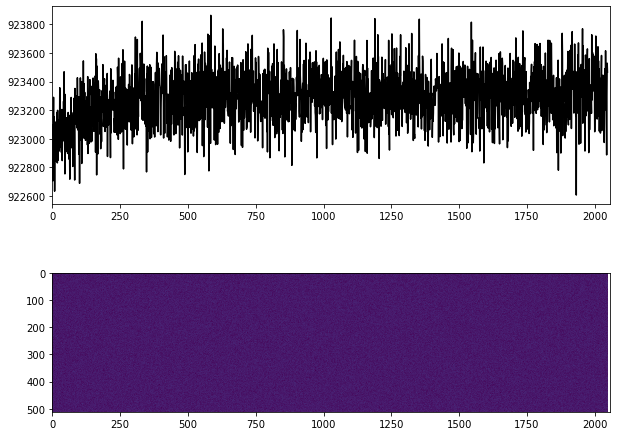

In [20]:
name=("bg_2_")
# name=("Bg_3_")
exposure = 4* 1e3 # ms
# tag="background"
tag="plasama-15torr"
# dye=""
# count=450000 # 615 nm
# count=480000 # 592 nm
# count=471000 # 601 nm
count=471000-10000 # 610 nm
# count=740000 # 307.5 nm
# count=800000 # 226 nm
# count=100000 # 840 nm
# count=666000 # Hdelta
# count=644000 # Hgamma
# count=595000 # Hbeta
# count=411000 # Halpha
# count=213000 # OI
# count=638000 # 435.2-447 [655(13100)-685(13700)]
# count=634000 # 439-450 [650(13-)-675(13-)]
# count=630000 # 444-455 [640(12-)-663(12-)]
# count=630000 # 444-455 [640(12-)-663(12-)]


for i in range(10):
    step_motor.goto(count)
    step_motor.waitUntilReady()
    vbin = 1
    attributes = {
        "temperature": camera.getTemperature(),
        "device_status": camera.getDeviceStatus(),
        "exposure": exposure,
        "frame_type": "light",
    }
    camera.setExposureTime(exposure);camera.setVBin(vbin);camera.setImageArea(10,0,2058,512//vbin);camera.exposeFrame()
    time.sleep(.1)
    # load image
    image_data = camera.grabFrame(out=np.empty((512//vbin,2048), np.uint16))
    # convert to xarray
    data = xr.DataArray(
        image_data, dims=["y", "x"], coords={"image_counter": 0}, attrs=attributes
    )
    # save data as NetCDF file
    filepath = join(basepath,f'{name}-{count}-{exposure}ms-{tag}_{i}.nc')
    data.to_netcdf(filepath)
plot_image(image_data)

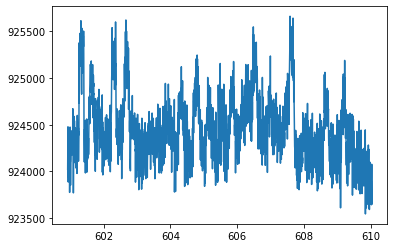

In [18]:
# filepath = join(basepath,f'{name}-{411000}-{exposure}ms-{tag}.nc')
convert_data = convert_nc(filepath)
plt.plot(convert_data[1],convert_data[0])
# plt.axvline(410.17, ls='--')
# plt.axvline(434.0472, ls='--')
# plt.axvline(486.13, ls='--')
# plt.axvline(656.28, ls='--')
# plt.axvline(435)

In [39]:
## reset
count =2000
step_motor.goto(count)
step_motor.waitUntilReady()

# LOOP

In [13]:
name=("background")
tag=""
ampere = 10
# R = range(200000,805000,5000)
R = [471000]*40
# R = [411000,595000,644000]
# R = [180000,185000,195000]
# R = [500000+2000*i for i in range()]
# R = [(i+1)*5000 for i in range(200)]
# R = [420000]
# T = [60e3,10e3,60e3,60e3]
T = [5e3]*len(R)
# T = [60e3]*6
# T = [10e3]*4 #H2onlyloop
# T = [100e3,50e3,50e3,50e3] #H2O2loop
# T = [10e3]*100
hour=datetime.datetime.now().hour;minute=datetime.datetime.now().minute
step_motor.goto(R[0]);step_motor.waitUntilReady();vbin = 1

image_data=np.zeros((512//1,2048), np.uint16)
print(image_data)
for i in range(len(R)):
    # if ccw_limit < R[i] < cw_limit:
    attributes = {
            "temperature": camera.getTemperature(),
            "device_status": camera.getDeviceStatus(),
            "exposure": T[i],
            "frame_type": "light",
        }
    camera.setExposureTime(T[i]);camera.setVBin(vbin);camera.setImageArea(10,0,2058,512//vbin)
    camera.exposeFrame()
    time.sleep(.1)
    print(camera.grabFrame(out=np.empty((512//vbin,2048), np.uint16)))
    # image_data += camera.grabFrame(out=np.empty((512//vbin,2048), np.uint16)) # load image
data = xr.DataArray(image_data, dims=["y", "x"], coords={"image_counter": 0}, attrs=attributes) # convert to xarray
        # plot_image(image_data)
        # filepath = join(basepath,f'{name}-{R[i]}-{T[i]}ms-{ampere}A-{tag}-{hour}{minute}.nc')
filepath = join(basepath,f'{name}-{R[i]}-{T[i]}ms-{hour}{minute}-{tag}.nc')
data.to_netcdf(filepath) # save data as NetCDF file
    # else:
        # print("out of range")
        # break

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [1]:
import sys
print(sys.getrecursionlimit())

sys.exit()

3000


SystemExit: 

c:\Users\fujii\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
